<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[04:09:58] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


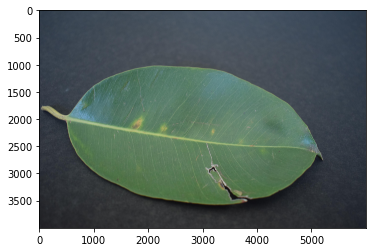

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

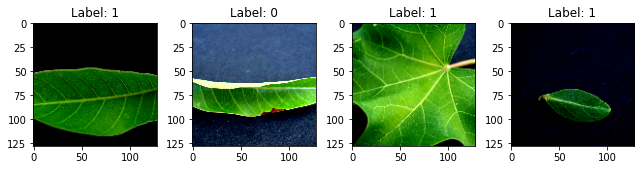

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
device = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, device=device)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), device=device))
model.hybridize()

[04:10:05] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[04:10:07] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.to_device(device))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.to_device(device))
            loss = loss_fn(outputs, label.to_device(device))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2520890706949928 samples/sec                   batch loss = 1.1732892990112305 | accuracy = 0.65


Epoch[1] Batch[10] Speed: 1.2613114733886026 samples/sec                   batch loss = 0.9540888071060181 | accuracy = 0.6


Epoch[1] Batch[15] Speed: 1.2594141251193096 samples/sec                   batch loss = 0.4275543689727783 | accuracy = 0.6


Epoch[1] Batch[20] Speed: 1.2593012540533448 samples/sec                   batch loss = 0.3209190368652344 | accuracy = 0.625


Epoch[1] Batch[25] Speed: 1.2630427985843442 samples/sec                   batch loss = 0.6280655860900879 | accuracy = 0.63


Epoch[1] Batch[30] Speed: 1.266360767400065 samples/sec                   batch loss = 0.47634151577949524 | accuracy = 0.6333333333333333


Epoch[1] Batch[35] Speed: 1.2631507303321976 samples/sec                   batch loss = 0.6156412959098816 | accuracy = 0.6142857142857143


Epoch[1] Batch[40] Speed: 1.2711686789646 samples/sec                   batch loss = 0.3296079635620117 | accuracy = 0.64375


Epoch[1] Batch[45] Speed: 1.2625819902000457 samples/sec                   batch loss = 0.8940193057060242 | accuracy = 0.65


Epoch[1] Batch[50] Speed: 1.2669270817601097 samples/sec                   batch loss = 0.5204276442527771 | accuracy = 0.645


Epoch[1] Batch[55] Speed: 1.2654150756158176 samples/sec                   batch loss = 0.4146604835987091 | accuracy = 0.6636363636363637


Epoch[1] Batch[60] Speed: 1.2673656968098708 samples/sec                   batch loss = 0.3757880628108978 | accuracy = 0.6583333333333333


Epoch[1] Batch[65] Speed: 1.2700676162060571 samples/sec                   batch loss = 0.6996145844459534 | accuracy = 0.6423076923076924


Epoch[1] Batch[70] Speed: 1.2748840065782165 samples/sec                   batch loss = 0.6770591735839844 | accuracy = 0.6392857142857142


Epoch[1] Batch[75] Speed: 1.2662483680572905 samples/sec                   batch loss = 0.826225757598877 | accuracy = 0.6233333333333333


Epoch[1] Batch[80] Speed: 1.2633276451565634 samples/sec                   batch loss = 0.7120676040649414 | accuracy = 0.621875


Epoch[1] Batch[85] Speed: 1.269233419967719 samples/sec                   batch loss = 1.1231131553649902 | accuracy = 0.6147058823529412


Epoch[1] Batch[90] Speed: 1.2636633488116356 samples/sec                   batch loss = 0.6694649457931519 | accuracy = 0.6166666666666667


Epoch[1] Batch[95] Speed: 1.2640798006310296 samples/sec                   batch loss = 1.0579787492752075 | accuracy = 0.6078947368421053


Epoch[1] Batch[100] Speed: 1.2701366531947762 samples/sec                   batch loss = 0.3323405981063843 | accuracy = 0.6075


Epoch[1] Batch[105] Speed: 1.272141802896764 samples/sec                   batch loss = 0.7290947437286377 | accuracy = 0.6047619047619047


Epoch[1] Batch[110] Speed: 1.2686124724996986 samples/sec                   batch loss = 0.39000776410102844 | accuracy = 0.6022727272727273


Epoch[1] Batch[115] Speed: 1.273896721464705 samples/sec                   batch loss = 0.7539802193641663 | accuracy = 0.6021739130434782


Epoch[1] Batch[120] Speed: 1.2717389170369509 samples/sec                   batch loss = 0.7594841122627258 | accuracy = 0.6083333333333333


Epoch[1] Batch[125] Speed: 1.2704926300714168 samples/sec                   batch loss = 0.47673794627189636 | accuracy = 0.612


Epoch[1] Batch[130] Speed: 1.2711091601036724 samples/sec                   batch loss = 0.44072380661964417 | accuracy = 0.6153846153846154


Epoch[1] Batch[135] Speed: 1.2698349841278347 samples/sec                   batch loss = 0.7573728561401367 | accuracy = 0.6148148148148148


Epoch[1] Batch[140] Speed: 1.2654327328997563 samples/sec                   batch loss = 0.6401399970054626 | accuracy = 0.6196428571428572


Epoch[1] Batch[145] Speed: 1.266067003716727 samples/sec                   batch loss = 1.015904426574707 | accuracy = 0.6258620689655172


Epoch[1] Batch[150] Speed: 1.2628436249837038 samples/sec                   batch loss = 0.6580155491828918 | accuracy = 0.6266666666666667


Epoch[1] Batch[155] Speed: 1.2621575039740485 samples/sec                   batch loss = 0.7016817331314087 | accuracy = 0.6241935483870967


Epoch[1] Batch[160] Speed: 1.2640651335136068 samples/sec                   batch loss = 0.8564813733100891 | accuracy = 0.621875


Epoch[1] Batch[165] Speed: 1.2706722812738551 samples/sec                   batch loss = 0.5475512742996216 | accuracy = 0.6242424242424243


Epoch[1] Batch[170] Speed: 1.2643745484838478 samples/sec                   batch loss = 1.124535083770752 | accuracy = 0.6264705882352941


Epoch[1] Batch[175] Speed: 1.2600692522200765 samples/sec                   batch loss = 0.42492246627807617 | accuracy = 0.6285714285714286


Epoch[1] Batch[180] Speed: 1.2625925371258535 samples/sec                   batch loss = 0.31502437591552734 | accuracy = 0.6333333333333333


Epoch[1] Batch[185] Speed: 1.258011481147167 samples/sec                   batch loss = 0.5619508624076843 | accuracy = 0.6351351351351351


Epoch[1] Batch[190] Speed: 1.2655615028041969 samples/sec                   batch loss = 0.968575656414032 | accuracy = 0.6328947368421053


Epoch[1] Batch[195] Speed: 1.2650813025019514 samples/sec                   batch loss = 0.7067952156066895 | accuracy = 0.632051282051282


Epoch[1] Batch[200] Speed: 1.2587373909366524 samples/sec                   batch loss = 0.4235319495201111 | accuracy = 0.635


Epoch[1] Batch[205] Speed: 1.260756230582034 samples/sec                   batch loss = 0.36666303873062134 | accuracy = 0.6365853658536585


Epoch[1] Batch[210] Speed: 1.2658642964467073 samples/sec                   batch loss = 0.5952894687652588 | accuracy = 0.6404761904761904


Epoch[1] Batch[215] Speed: 1.2618339881969611 samples/sec                   batch loss = 0.4354074001312256 | accuracy = 0.6372093023255814


Epoch[1] Batch[220] Speed: 1.2669836262391294 samples/sec                   batch loss = 0.825359582901001 | accuracy = 0.6352272727272728


Epoch[1] Batch[225] Speed: 1.2657262022848415 samples/sec                   batch loss = 0.36213210225105286 | accuracy = 0.6388888888888888


Epoch[1] Batch[230] Speed: 1.264013801282893 samples/sec                   batch loss = 0.2825576066970825 | accuracy = 0.6413043478260869


Epoch[1] Batch[235] Speed: 1.2617358650852692 samples/sec                   batch loss = 0.2785792648792267 | accuracy = 0.6425531914893617


Epoch[1] Batch[240] Speed: 1.261550478739347 samples/sec                   batch loss = 0.5521027445793152 | accuracy = 0.6458333333333334


Epoch[1] Batch[245] Speed: 1.2614224288952467 samples/sec                   batch loss = 0.8348354697227478 | accuracy = 0.6489795918367347


Epoch[1] Batch[250] Speed: 1.2660669081749198 samples/sec                   batch loss = 0.16156145930290222 | accuracy = 0.651


Epoch[1] Batch[255] Speed: 1.2672636484018234 samples/sec                   batch loss = 0.2688959538936615 | accuracy = 0.6549019607843137


Epoch[1] Batch[260] Speed: 1.2655698083603324 samples/sec                   batch loss = 0.6764507293701172 | accuracy = 0.6567307692307692


Epoch[1] Batch[265] Speed: 1.261965254091631 samples/sec                   batch loss = 0.3987528681755066 | accuracy = 0.659433962264151


Epoch[1] Batch[270] Speed: 1.262666180482098 samples/sec                   batch loss = 0.6316807866096497 | accuracy = 0.6592592592592592


Epoch[1] Batch[275] Speed: 1.2639892318574828 samples/sec                   batch loss = 1.0873792171478271 | accuracy = 0.6609090909090909


Epoch[1] Batch[280] Speed: 1.2652969276614994 samples/sec                   batch loss = 0.9363454580307007 | accuracy = 0.6607142857142857


Epoch[1] Batch[285] Speed: 1.2678197529169983 samples/sec                   batch loss = 0.3099711239337921 | accuracy = 0.6578947368421053


Epoch[1] Batch[290] Speed: 1.2658685944663308 samples/sec                   batch loss = 0.8078776597976685 | accuracy = 0.6560344827586206


Epoch[1] Batch[295] Speed: 1.2648404807673894 samples/sec                   batch loss = 0.6201296448707581 | accuracy = 0.6559322033898305


Epoch[1] Batch[300] Speed: 1.2630682821265378 samples/sec                   batch loss = 0.5444399118423462 | accuracy = 0.6558333333333334


Epoch[1] Batch[305] Speed: 1.2639121967124392 samples/sec                   batch loss = 0.753853440284729 | accuracy = 0.6581967213114754


Epoch[1] Batch[310] Speed: 1.2655046079026604 samples/sec                   batch loss = 0.39397186040878296 | accuracy = 0.657258064516129


Epoch[1] Batch[315] Speed: 1.2676343943763304 samples/sec                   batch loss = 0.9170099496841431 | accuracy = 0.6579365079365079


Epoch[1] Batch[320] Speed: 1.25746790432634 samples/sec                   batch loss = 0.6880835294723511 | accuracy = 0.66015625


Epoch[1] Batch[325] Speed: 1.2603683816205393 samples/sec                   batch loss = 0.19501568377017975 | accuracy = 0.6615384615384615


Epoch[1] Batch[330] Speed: 1.2646041354593163 samples/sec                   batch loss = 0.25755301117897034 | accuracy = 0.6643939393939394


Epoch[1] Batch[335] Speed: 1.270683060036862 samples/sec                   batch loss = 0.28140440583229065 | accuracy = 0.6656716417910448


Epoch[1] Batch[340] Speed: 1.2686860523009225 samples/sec                   batch loss = 0.3699423670768738 | accuracy = 0.6654411764705882


Epoch[1] Batch[345] Speed: 1.271728023955509 samples/sec                   batch loss = 0.49558135867118835 | accuracy = 0.6681159420289855


Epoch[1] Batch[350] Speed: 1.2676909062237405 samples/sec                   batch loss = 1.1557323932647705 | accuracy = 0.6657142857142857


Epoch[1] Batch[355] Speed: 1.2717817199782988 samples/sec                   batch loss = 0.4682627320289612 | accuracy = 0.6669014084507042


Epoch[1] Batch[360] Speed: 1.268294939752041 samples/sec                   batch loss = 0.45652058720588684 | accuracy = 0.6694444444444444


Epoch[1] Batch[365] Speed: 1.2675324942205508 samples/sec                   batch loss = 0.6015795469284058 | accuracy = 0.6678082191780822


Epoch[1] Batch[370] Speed: 1.2708684448798873 samples/sec                   batch loss = 0.9566349983215332 | accuracy = 0.6675675675675675


Epoch[1] Batch[375] Speed: 1.2663017934880607 samples/sec                   batch loss = 0.48756715655326843 | accuracy = 0.6693333333333333


Epoch[1] Batch[380] Speed: 1.2686644667288198 samples/sec                   batch loss = 0.5489511489868164 | accuracy = 0.6717105263157894


Epoch[1] Batch[385] Speed: 1.2688475356790236 samples/sec                   batch loss = 0.5342387557029724 | accuracy = 0.672077922077922


Epoch[1] Batch[390] Speed: 1.2628251844008134 samples/sec                   batch loss = 0.6170584559440613 | accuracy = 0.6717948717948717


Epoch[1] Batch[395] Speed: 1.2530486324790027 samples/sec                   batch loss = 0.32936447858810425 | accuracy = 0.6734177215189874


Epoch[1] Batch[400] Speed: 1.2625285931539878 samples/sec                   batch loss = 0.636850118637085 | accuracy = 0.6725


Epoch[1] Batch[405] Speed: 1.2676115994979182 samples/sec                   batch loss = 0.5627216696739197 | accuracy = 0.674074074074074


Epoch[1] Batch[410] Speed: 1.2607045983301985 samples/sec                   batch loss = 0.28534045815467834 | accuracy = 0.675609756097561


Epoch[1] Batch[415] Speed: 1.2595495214606773 samples/sec                   batch loss = 0.2761479318141937 | accuracy = 0.6759036144578313


Epoch[1] Batch[420] Speed: 1.2659096659035993 samples/sec                   batch loss = 0.6603545546531677 | accuracy = 0.6755952380952381


Epoch[1] Batch[425] Speed: 1.262810546383397 samples/sec                   batch loss = 0.4721442759037018 | accuracy = 0.6752941176470588


Epoch[1] Batch[430] Speed: 1.2647791693243624 samples/sec                   batch loss = 1.0005688667297363 | accuracy = 0.6761627906976744


Epoch[1] Batch[435] Speed: 1.2688614503118227 samples/sec                   batch loss = 0.5866755843162537 | accuracy = 0.6752873563218391


Epoch[1] Batch[440] Speed: 1.2622120091640663 samples/sec                   batch loss = 0.3991315960884094 | accuracy = 0.6744318181818182


Epoch[1] Batch[445] Speed: 1.2680179117978188 samples/sec                   batch loss = 0.33062219619750977 | accuracy = 0.6747191011235955


Epoch[1] Batch[450] Speed: 1.2672809744122369 samples/sec                   batch loss = 0.5747483372688293 | accuracy = 0.6744444444444444


Epoch[1] Batch[455] Speed: 1.2615377674445185 samples/sec                   batch loss = 0.2982233464717865 | accuracy = 0.6758241758241759


Epoch[1] Batch[460] Speed: 1.2589329095773343 samples/sec                   batch loss = 0.027580635622143745 | accuracy = 0.6766304347826086


Epoch[1] Batch[465] Speed: 1.2624260872849888 samples/sec                   batch loss = 0.344675213098526 | accuracy = 0.6779569892473118


Epoch[1] Batch[470] Speed: 1.2642936553803077 samples/sec                   batch loss = 0.47245076298713684 | accuracy = 0.6787234042553192


Epoch[1] Batch[475] Speed: 1.2650765328647602 samples/sec                   batch loss = 0.20434227585792542 | accuracy = 0.6794736842105263


Epoch[1] Batch[480] Speed: 1.2585529790196361 samples/sec                   batch loss = 1.509628415107727 | accuracy = 0.6796875


Epoch[1] Batch[485] Speed: 1.2623698538793917 samples/sec                   batch loss = 0.6082748770713806 | accuracy = 0.6809278350515464


Epoch[1] Batch[490] Speed: 1.2652383390410482 samples/sec                   batch loss = 0.5031195878982544 | accuracy = 0.6821428571428572


Epoch[1] Batch[495] Speed: 1.2646973664224421 samples/sec                   batch loss = 0.5293264389038086 | accuracy = 0.6813131313131313


Epoch[1] Batch[500] Speed: 1.2683417301207363 samples/sec                   batch loss = 0.884712815284729 | accuracy = 0.6815


Epoch[1] Batch[505] Speed: 1.2642692656157324 samples/sec                   batch loss = 0.18736861646175385 | accuracy = 0.6816831683168317


Epoch[1] Batch[510] Speed: 1.2650987596807803 samples/sec                   batch loss = 0.42747241258621216 | accuracy = 0.6813725490196079


Epoch[1] Batch[515] Speed: 1.2634528470888544 samples/sec                   batch loss = 0.5947118997573853 | accuracy = 0.683495145631068


Epoch[1] Batch[520] Speed: 1.264062752520163 samples/sec                   batch loss = 1.2987391948699951 | accuracy = 0.6826923076923077


Epoch[1] Batch[525] Speed: 1.263090628616084 samples/sec                   batch loss = 0.7582859396934509 | accuracy = 0.6838095238095238


Epoch[1] Batch[530] Speed: 1.2665648767366726 samples/sec                   batch loss = 0.5398852229118347 | accuracy = 0.6839622641509434


Epoch[1] Batch[535] Speed: 1.2734325034812677 samples/sec                   batch loss = 0.345548152923584 | accuracy = 0.6836448598130841


Epoch[1] Batch[540] Speed: 1.2688838103265105 samples/sec                   batch loss = 0.4999852776527405 | accuracy = 0.6851851851851852


Epoch[1] Batch[545] Speed: 1.264313949143839 samples/sec                   batch loss = 0.43212205171585083 | accuracy = 0.6857798165137615


Epoch[1] Batch[550] Speed: 1.2603806906184245 samples/sec                   batch loss = 0.6570273637771606 | accuracy = 0.6859090909090909


Epoch[1] Batch[555] Speed: 1.2631675636418722 samples/sec                   batch loss = 0.7315540313720703 | accuracy = 0.6842342342342342


Epoch[1] Batch[560] Speed: 1.2570882922131812 samples/sec                   batch loss = 1.0241084098815918 | accuracy = 0.6839285714285714


Epoch[1] Batch[565] Speed: 1.2645467547272915 samples/sec                   batch loss = 0.5429481267929077 | accuracy = 0.6862831858407079


Epoch[1] Batch[570] Speed: 1.2634043236381962 samples/sec                   batch loss = 0.5285362005233765 | accuracy = 0.6859649122807018


Epoch[1] Batch[575] Speed: 1.268325046273575 samples/sec                   batch loss = 0.8355490565299988 | accuracy = 0.6856521739130435


Epoch[1] Batch[580] Speed: 1.2670868735960983 samples/sec                   batch loss = 0.5363609790802002 | accuracy = 0.6857758620689656


Epoch[1] Batch[585] Speed: 1.2692887300762177 samples/sec                   batch loss = 1.0038588047027588 | accuracy = 0.6863247863247863


Epoch[1] Batch[590] Speed: 1.2731192195501 samples/sec                   batch loss = 0.4916325807571411 | accuracy = 0.686864406779661


Epoch[1] Batch[595] Speed: 1.2647684904895564 samples/sec                   batch loss = 0.41562214493751526 | accuracy = 0.6873949579831933


Epoch[1] Batch[600] Speed: 1.2659150149380878 samples/sec                   batch loss = 0.3495998978614807 | accuracy = 0.6866666666666666


Epoch[1] Batch[605] Speed: 1.2677547036176977 samples/sec                   batch loss = 0.5049905776977539 | accuracy = 0.6859504132231405


Epoch[1] Batch[610] Speed: 1.266019712285123 samples/sec                   batch loss = 0.7268916368484497 | accuracy = 0.6864754098360656


Epoch[1] Batch[615] Speed: 1.2620400584426024 samples/sec                   batch loss = 0.4653473496437073 | accuracy = 0.6873983739837398


Epoch[1] Batch[620] Speed: 1.2754077458832387 samples/sec                   batch loss = 0.6527737975120544 | accuracy = 0.6870967741935484


Epoch[1] Batch[625] Speed: 1.2665100905818216 samples/sec                   batch loss = 0.4693654477596283 | accuracy = 0.688


Epoch[1] Batch[630] Speed: 1.2631325660775763 samples/sec                   batch loss = 0.27543413639068604 | accuracy = 0.6888888888888889


Epoch[1] Batch[635] Speed: 1.2666983720979923 samples/sec                   batch loss = 0.27188724279403687 | accuracy = 0.6901574803149606


Epoch[1] Batch[640] Speed: 1.2650212077015628 samples/sec                   batch loss = 0.39983439445495605 | accuracy = 0.691015625


Epoch[1] Batch[645] Speed: 1.26879015303861 samples/sec                   batch loss = 0.3310393691062927 | accuracy = 0.6903100775193799


Epoch[1] Batch[650] Speed: 1.265353708456062 samples/sec                   batch loss = 0.8441638350486755 | accuracy = 0.69


Epoch[1] Batch[655] Speed: 1.2610154978816235 samples/sec                   batch loss = 0.7077651023864746 | accuracy = 0.6893129770992367


Epoch[1] Batch[660] Speed: 1.2688581875429483 samples/sec                   batch loss = 1.3153598308563232 | accuracy = 0.690530303030303


Epoch[1] Batch[665] Speed: 1.268568347899464 samples/sec                   batch loss = 0.3144485056400299 | accuracy = 0.6917293233082706


Epoch[1] Batch[670] Speed: 1.2630419428115944 samples/sec                   batch loss = 0.670402467250824 | accuracy = 0.6906716417910448


Epoch[1] Batch[675] Speed: 1.2652367169577394 samples/sec                   batch loss = 0.5648636817932129 | accuracy = 0.6922222222222222


Epoch[1] Batch[680] Speed: 1.2685986592513163 samples/sec                   batch loss = 1.3959863185882568 | accuracy = 0.6922794117647059


Epoch[1] Batch[685] Speed: 1.2714039196809233 samples/sec                   batch loss = 0.2562388479709625 | accuracy = 0.6930656934306569


Epoch[1] Batch[690] Speed: 1.2605978419311656 samples/sec                   batch loss = 0.518153965473175 | accuracy = 0.6942028985507246


Epoch[1] Batch[695] Speed: 1.266100826422581 samples/sec                   batch loss = 0.7682769894599915 | accuracy = 0.6946043165467626


Epoch[1] Batch[700] Speed: 1.2674757092318065 samples/sec                   batch loss = 0.2815578877925873 | accuracy = 0.695


Epoch[1] Batch[705] Speed: 1.2713734741270835 samples/sec                   batch loss = 0.7492414712905884 | accuracy = 0.6960992907801419


Epoch[1] Batch[710] Speed: 1.266070634316087 samples/sec                   batch loss = 0.8007519245147705 | accuracy = 0.6957746478873239


Epoch[1] Batch[715] Speed: 1.263835266162073 samples/sec                   batch loss = 0.2596248388290405 | accuracy = 0.6954545454545454


Epoch[1] Batch[720] Speed: 1.2673800576610088 samples/sec                   batch loss = 1.1190682649612427 | accuracy = 0.6961805555555556


Epoch[1] Batch[725] Speed: 1.263472067211601 samples/sec                   batch loss = 0.37227335572242737 | accuracy = 0.6962068965517242


Epoch[1] Batch[730] Speed: 1.2616483832654501 samples/sec                   batch loss = 0.707206130027771 | accuracy = 0.6958904109589041


Epoch[1] Batch[735] Speed: 1.2657416719163175 samples/sec                   batch loss = 0.7810930609703064 | accuracy = 0.6945578231292517


Epoch[1] Batch[740] Speed: 1.2633952853680046 samples/sec                   batch loss = 0.535951554775238 | accuracy = 0.6945945945945946


Epoch[1] Batch[745] Speed: 1.265677122130046 samples/sec                   batch loss = 0.7216979265213013 | accuracy = 0.6953020134228188


Epoch[1] Batch[750] Speed: 1.2635058465670128 samples/sec                   batch loss = 0.4128117859363556 | accuracy = 0.6953333333333334


Epoch[1] Batch[755] Speed: 1.2651772752442676 samples/sec                   batch loss = 0.44140106439590454 | accuracy = 0.695364238410596


Epoch[1] Batch[760] Speed: 1.2631407446825411 samples/sec                   batch loss = 0.36117178201675415 | accuracy = 0.6957236842105263


Epoch[1] Batch[765] Speed: 1.2666158426333312 samples/sec                   batch loss = 0.5348179340362549 | accuracy = 0.6964052287581699


Epoch[1] Batch[770] Speed: 1.2636671559984063 samples/sec                   batch loss = 0.39338433742523193 | accuracy = 0.6967532467532468


Epoch[1] Batch[775] Speed: 1.2645837370610222 samples/sec                   batch loss = 0.35076647996902466 | accuracy = 0.6980645161290323


Epoch[1] Batch[780] Speed: 1.262533628625589 samples/sec                   batch loss = 0.24663858115673065 | accuracy = 0.6974358974358974


Epoch[1] Batch[785] Speed: 1.270815884804678 samples/sec                   batch loss = 0.31554150581359863 | accuracy = 0.6984076433121019


[Epoch 1] training: accuracy=0.6982868020304569
[Epoch 1] time cost: 650.465080499649
[Epoch 1] validation: validation accuracy=0.7355555555555555


Epoch[2] Batch[5] Speed: 1.2616247595615706 samples/sec                   batch loss = 0.9307633638381958 | accuracy = 0.65


Epoch[2] Batch[10] Speed: 1.262862826575344 samples/sec                   batch loss = 0.6359694600105286 | accuracy = 0.7


Epoch[2] Batch[15] Speed: 1.2653877793790078 samples/sec                   batch loss = 0.438356876373291 | accuracy = 0.75


Epoch[2] Batch[20] Speed: 1.2609448900447213 samples/sec                   batch loss = 0.3665129840373993 | accuracy = 0.775


Epoch[2] Batch[25] Speed: 1.2587993458259263 samples/sec                   batch loss = 0.32122114300727844 | accuracy = 0.76


Epoch[2] Batch[30] Speed: 1.2647157663858752 samples/sec                   batch loss = 0.2722974419593811 | accuracy = 0.7833333333333333


Epoch[2] Batch[35] Speed: 1.264538081348767 samples/sec                   batch loss = 0.6834399104118347 | accuracy = 0.7642857142857142


Epoch[2] Batch[40] Speed: 1.2645130150005326 samples/sec                   batch loss = 0.441769003868103 | accuracy = 0.76875


Epoch[2] Batch[45] Speed: 1.2661566282827237 samples/sec                   batch loss = 0.9110823273658752 | accuracy = 0.75


Epoch[2] Batch[50] Speed: 1.2735011334370925 samples/sec                   batch loss = 0.3626468777656555 | accuracy = 0.755


Epoch[2] Batch[55] Speed: 1.267237325259536 samples/sec                   batch loss = 0.7123574614524841 | accuracy = 0.7318181818181818


Epoch[2] Batch[60] Speed: 1.2706600591477561 samples/sec                   batch loss = 0.19114987552165985 | accuracy = 0.725


Epoch[2] Batch[65] Speed: 1.2633056707816754 samples/sec                   batch loss = 0.2582056224346161 | accuracy = 0.7346153846153847


Epoch[2] Batch[70] Speed: 1.2666265526865923 samples/sec                   batch loss = 1.5449703931808472 | accuracy = 0.7392857142857143


Epoch[2] Batch[75] Speed: 1.2550288779346965 samples/sec                   batch loss = 1.9508635997772217 | accuracy = 0.72


Epoch[2] Batch[80] Speed: 1.2640479905610125 samples/sec                   batch loss = 0.531317412853241 | accuracy = 0.715625


Epoch[2] Batch[85] Speed: 1.2616830139885808 samples/sec                   batch loss = 0.4294555187225342 | accuracy = 0.7176470588235294


Epoch[2] Batch[90] Speed: 1.2660755069953225 samples/sec                   batch loss = 1.280996561050415 | accuracy = 0.7138888888888889


Epoch[2] Batch[95] Speed: 1.261940574398589 samples/sec                   batch loss = 0.4983232021331787 | accuracy = 0.7078947368421052


Epoch[2] Batch[100] Speed: 1.2637909972566364 samples/sec                   batch loss = 0.24295608699321747 | accuracy = 0.7075


Epoch[2] Batch[105] Speed: 1.2613410596150962 samples/sec                   batch loss = 0.5056925415992737 | accuracy = 0.7095238095238096


Epoch[2] Batch[110] Speed: 1.2609986271023201 samples/sec                   batch loss = 0.7035950422286987 | accuracy = 0.7113636363636363


Epoch[2] Batch[115] Speed: 1.2615259101242975 samples/sec                   batch loss = 0.3051234185695648 | accuracy = 0.717391304347826


Epoch[2] Batch[120] Speed: 1.26124367685424 samples/sec                   batch loss = 0.35966673493385315 | accuracy = 0.7208333333333333


Epoch[2] Batch[125] Speed: 1.257088763170808 samples/sec                   batch loss = 0.18333272635936737 | accuracy = 0.724


Epoch[2] Batch[130] Speed: 1.2598707314327655 samples/sec                   batch loss = 0.7729347348213196 | accuracy = 0.7230769230769231


Epoch[2] Batch[135] Speed: 1.264651893161847 samples/sec                   batch loss = 0.46902164816856384 | accuracy = 0.725925925925926


Epoch[2] Batch[140] Speed: 1.2648386689909987 samples/sec                   batch loss = 0.5296385884284973 | accuracy = 0.7214285714285714


Epoch[2] Batch[145] Speed: 1.258062515686211 samples/sec                   batch loss = 0.24421289563179016 | accuracy = 0.7189655172413794


Epoch[2] Batch[150] Speed: 1.2648266541841686 samples/sec                   batch loss = 0.8710071444511414 | accuracy = 0.7216666666666667


Epoch[2] Batch[155] Speed: 1.262189883667419 samples/sec                   batch loss = 0.4190189242362976 | accuracy = 0.7241935483870968


Epoch[2] Batch[160] Speed: 1.2630893924066395 samples/sec                   batch loss = 0.5134164690971375 | accuracy = 0.7234375


Epoch[2] Batch[165] Speed: 1.2639801852166324 samples/sec                   batch loss = 0.7426661849021912 | accuracy = 0.7227272727272728


Epoch[2] Batch[170] Speed: 1.259654303413081 samples/sec                   batch loss = 0.45616835355758667 | accuracy = 0.725


Epoch[2] Batch[175] Speed: 1.2628307925623332 samples/sec                   batch loss = 0.26901519298553467 | accuracy = 0.7228571428571429


Epoch[2] Batch[180] Speed: 1.2624736806183625 samples/sec                   batch loss = 0.300005704164505 | accuracy = 0.725


Epoch[2] Batch[185] Speed: 1.2599628872597441 samples/sec                   batch loss = 0.39384394884109497 | accuracy = 0.727027027027027


Epoch[2] Batch[190] Speed: 1.2592202527024439 samples/sec                   batch loss = 0.6144347786903381 | accuracy = 0.7263157894736842


Epoch[2] Batch[195] Speed: 1.261145645525441 samples/sec                   batch loss = 0.5582799911499023 | accuracy = 0.7282051282051282


Epoch[2] Batch[200] Speed: 1.2638915349888238 samples/sec                   batch loss = 0.514473557472229 | accuracy = 0.72875


Epoch[2] Batch[205] Speed: 1.265555488504013 samples/sec                   batch loss = 0.5339363813400269 | accuracy = 0.7292682926829268


Epoch[2] Batch[210] Speed: 1.2599738635954851 samples/sec                   batch loss = 0.47950372099876404 | accuracy = 0.7273809523809524


Epoch[2] Batch[215] Speed: 1.2610828907222642 samples/sec                   batch loss = 0.35538116097450256 | accuracy = 0.7302325581395349


Epoch[2] Batch[220] Speed: 1.2620379698759168 samples/sec                   batch loss = 0.4699682593345642 | accuracy = 0.7295454545454545


Epoch[2] Batch[225] Speed: 1.2631667077000452 samples/sec                   batch loss = 0.4035179913043976 | accuracy = 0.7322222222222222


Epoch[2] Batch[230] Speed: 1.2626404280865655 samples/sec                   batch loss = 0.5253924131393433 | accuracy = 0.7347826086956522


Epoch[2] Batch[235] Speed: 1.2619742719125768 samples/sec                   batch loss = 0.21520783007144928 | accuracy = 0.7361702127659574


Epoch[2] Batch[240] Speed: 1.2664476611782438 samples/sec                   batch loss = 0.2159399837255478 | accuracy = 0.7364583333333333


Epoch[2] Batch[245] Speed: 1.2658260931105452 samples/sec                   batch loss = 0.49390101432800293 | accuracy = 0.7357142857142858


Epoch[2] Batch[250] Speed: 1.2668546624476478 samples/sec                   batch loss = 0.8217160701751709 | accuracy = 0.734


Epoch[2] Batch[255] Speed: 1.2674433450222384 samples/sec                   batch loss = 1.5570778846740723 | accuracy = 0.7313725490196078


Epoch[2] Batch[260] Speed: 1.2689013726073308 samples/sec                   batch loss = 0.5538627505302429 | accuracy = 0.7278846153846154


Epoch[2] Batch[265] Speed: 1.2643068033781433 samples/sec                   batch loss = 0.7127754092216492 | accuracy = 0.7283018867924528


Epoch[2] Batch[270] Speed: 1.2609382561576954 samples/sec                   batch loss = 0.6159490346908569 | accuracy = 0.7287037037037037


Epoch[2] Batch[275] Speed: 1.2610427005944946 samples/sec                   batch loss = 0.37762174010276794 | accuracy = 0.7263636363636363


Epoch[2] Batch[280] Speed: 1.2547562067077473 samples/sec                   batch loss = 0.4519882798194885 | accuracy = 0.7267857142857143


Epoch[2] Batch[285] Speed: 1.265178992582996 samples/sec                   batch loss = 0.6395511031150818 | accuracy = 0.7271929824561404


Epoch[2] Batch[290] Speed: 1.27117060523444 samples/sec                   batch loss = 0.6941912174224854 | accuracy = 0.7293103448275862


Epoch[2] Batch[295] Speed: 1.2693718003193477 samples/sec                   batch loss = 0.23664960265159607 | accuracy = 0.7296610169491525


Epoch[2] Batch[300] Speed: 1.2671725271288274 samples/sec                   batch loss = 0.6964430809020996 | accuracy = 0.73


Epoch[2] Batch[305] Speed: 1.2672536933394314 samples/sec                   batch loss = 0.7103170156478882 | accuracy = 0.7327868852459016


Epoch[2] Batch[310] Speed: 1.2710396321828212 samples/sec                   batch loss = 0.1607631891965866 | accuracy = 0.7346774193548387


Epoch[2] Batch[315] Speed: 1.2690637747584144 samples/sec                   batch loss = 0.8480501174926758 | accuracy = 0.7341269841269841


Epoch[2] Batch[320] Speed: 1.2708677710052565 samples/sec                   batch loss = 0.9083788990974426 | accuracy = 0.7328125


Epoch[2] Batch[325] Speed: 1.2715159834405687 samples/sec                   batch loss = 0.8377984762191772 | accuracy = 0.7315384615384616


Epoch[2] Batch[330] Speed: 1.2693367462317784 samples/sec                   batch loss = 0.5330597162246704 | accuracy = 0.7310606060606061


Epoch[2] Batch[335] Speed: 1.2748913692857646 samples/sec                   batch loss = 0.40913429856300354 | accuracy = 0.732089552238806


Epoch[2] Batch[340] Speed: 1.2728421082339616 samples/sec                   batch loss = 0.889812707901001 | accuracy = 0.7323529411764705


Epoch[2] Batch[345] Speed: 1.2678032744072225 samples/sec                   batch loss = 0.4799706041812897 | accuracy = 0.7340579710144928


Epoch[2] Batch[350] Speed: 1.263217210252671 samples/sec                   batch loss = 1.1767092943191528 | accuracy = 0.7364285714285714


Epoch[2] Batch[355] Speed: 1.2662558224979297 samples/sec                   batch loss = 0.260174423456192 | accuracy = 0.7373239436619718


Epoch[2] Batch[360] Speed: 1.2726478448896112 samples/sec                   batch loss = 0.8239990472793579 | accuracy = 0.7354166666666667


Epoch[2] Batch[365] Speed: 1.2632561123355066 samples/sec                   batch loss = 0.45687398314476013 | accuracy = 0.736986301369863


Epoch[2] Batch[370] Speed: 1.2594814414492055 samples/sec                   batch loss = 0.61626136302948 | accuracy = 0.7364864864864865


Epoch[2] Batch[375] Speed: 1.2670272579162885 samples/sec                   batch loss = 0.5457799434661865 | accuracy = 0.7373333333333333


Epoch[2] Batch[380] Speed: 1.2624150681824784 samples/sec                   batch loss = 0.25021296739578247 | accuracy = 0.7388157894736842


Epoch[2] Batch[385] Speed: 1.2596372798882205 samples/sec                   batch loss = 0.1514522284269333 | accuracy = 0.7383116883116884


Epoch[2] Batch[390] Speed: 1.2599145368850495 samples/sec                   batch loss = 1.4021059274673462 | accuracy = 0.7352564102564103


Epoch[2] Batch[395] Speed: 1.2592261124271715 samples/sec                   batch loss = 0.3308171033859253 | accuracy = 0.7341772151898734


Epoch[2] Batch[400] Speed: 1.2627673947224425 samples/sec                   batch loss = 1.055990219116211 | accuracy = 0.73375


Epoch[2] Batch[405] Speed: 1.261622008264018 samples/sec                   batch loss = 0.6019077897071838 | accuracy = 0.7339506172839506


Epoch[2] Batch[410] Speed: 1.2613350853613712 samples/sec                   batch loss = 0.7043182253837585 | accuracy = 0.7353658536585366


Epoch[2] Batch[415] Speed: 1.2623947403429587 samples/sec                   batch loss = 0.30178600549697876 | accuracy = 0.736144578313253


Epoch[2] Batch[420] Speed: 1.2636772451542966 samples/sec                   batch loss = 0.32482367753982544 | accuracy = 0.736904761904762


Epoch[2] Batch[425] Speed: 1.2615474431829716 samples/sec                   batch loss = 0.5498790740966797 | accuracy = 0.7382352941176471


Epoch[2] Batch[430] Speed: 1.260513264295131 samples/sec                   batch loss = 0.804579496383667 | accuracy = 0.7383720930232558


Epoch[2] Batch[435] Speed: 1.2638397408261686 samples/sec                   batch loss = 0.4761325418949127 | accuracy = 0.7385057471264368


Epoch[2] Batch[440] Speed: 1.26751784263187 samples/sec                   batch loss = 0.277753621339798 | accuracy = 0.7397727272727272


Epoch[2] Batch[445] Speed: 1.2648492536528018 samples/sec                   batch loss = 1.144354224205017 | accuracy = 0.7393258426966293


Epoch[2] Batch[450] Speed: 1.2671802795842415 samples/sec                   batch loss = 0.39751556515693665 | accuracy = 0.7394444444444445


Epoch[2] Batch[455] Speed: 1.2635863533828273 samples/sec                   batch loss = 0.3784635365009308 | accuracy = 0.7401098901098901


Epoch[2] Batch[460] Speed: 1.2659581909428523 samples/sec                   batch loss = 0.25762438774108887 | accuracy = 0.7396739130434783


Epoch[2] Batch[465] Speed: 1.2634568433038478 samples/sec                   batch loss = 0.4933197796344757 | accuracy = 0.739247311827957


Epoch[2] Batch[470] Speed: 1.2632494541073713 samples/sec                   batch loss = 0.3187897503376007 | accuracy = 0.7388297872340426


Epoch[2] Batch[475] Speed: 1.2657640176071492 samples/sec                   batch loss = 0.39602506160736084 | accuracy = 0.738421052631579


Epoch[2] Batch[480] Speed: 1.2695096344756756 samples/sec                   batch loss = 0.48046255111694336 | accuracy = 0.7375


Epoch[2] Batch[485] Speed: 1.2658878881584303 samples/sec                   batch loss = 0.3717052936553955 | accuracy = 0.738659793814433


Epoch[2] Batch[490] Speed: 1.2658602849880576 samples/sec                   batch loss = 0.09247775375843048 | accuracy = 0.7397959183673469


Epoch[2] Batch[495] Speed: 1.2667096573797214 samples/sec                   batch loss = 0.22464539110660553 | accuracy = 0.7404040404040404


Epoch[2] Batch[500] Speed: 1.2679984572896654 samples/sec                   batch loss = 0.43151021003723145 | accuracy = 0.7425


Epoch[2] Batch[505] Speed: 1.2626023240704805 samples/sec                   batch loss = 0.15548431873321533 | accuracy = 0.7420792079207921


Epoch[2] Batch[510] Speed: 1.2676604466698256 samples/sec                   batch loss = 0.41524946689605713 | accuracy = 0.7426470588235294


Epoch[2] Batch[515] Speed: 1.2663185197284104 samples/sec                   batch loss = 0.4128211438655853 | accuracy = 0.7432038834951457


Epoch[2] Batch[520] Speed: 1.260945837748566 samples/sec                   batch loss = 0.5734612941741943 | accuracy = 0.7432692307692308


Epoch[2] Batch[525] Speed: 1.2609664032728636 samples/sec                   batch loss = 0.8518021702766418 | accuracy = 0.7428571428571429


Epoch[2] Batch[530] Speed: 1.272247436314511 samples/sec                   batch loss = 0.3403153717517853 | accuracy = 0.7415094339622641


Epoch[2] Batch[535] Speed: 1.2693588348832598 samples/sec                   batch loss = 0.32536450028419495 | accuracy = 0.7406542056074766


Epoch[2] Batch[540] Speed: 1.2666985633722785 samples/sec                   batch loss = 0.346694678068161 | accuracy = 0.7421296296296296


Epoch[2] Batch[545] Speed: 1.2656891530998686 samples/sec                   batch loss = 0.32727792859077454 | accuracy = 0.7435779816513761


Epoch[2] Batch[550] Speed: 1.270047329604114 samples/sec                   batch loss = 0.8748929500579834 | accuracy = 0.7427272727272727


Epoch[2] Batch[555] Speed: 1.2690123237156796 samples/sec                   batch loss = 0.12870602309703827 | accuracy = 0.7445945945945946


Epoch[2] Batch[560] Speed: 1.2686884507431642 samples/sec                   batch loss = 0.23378796875476837 | accuracy = 0.74375


Epoch[2] Batch[565] Speed: 1.270712125112749 samples/sec                   batch loss = 0.3796621561050415 | accuracy = 0.7442477876106195


Epoch[2] Batch[570] Speed: 1.2714046904733631 samples/sec                   batch loss = 0.649128258228302 | accuracy = 0.7451754385964913


Epoch[2] Batch[575] Speed: 1.2733910391069543 samples/sec                   batch loss = 0.529561460018158 | accuracy = 0.7460869565217392


Epoch[2] Batch[580] Speed: 1.2722875719648061 samples/sec                   batch loss = 0.27236104011535645 | accuracy = 0.7461206896551724


Epoch[2] Batch[585] Speed: 1.268711860015628 samples/sec                   batch loss = 0.2705880403518677 | accuracy = 0.7465811965811966


Epoch[2] Batch[590] Speed: 1.2669740582906288 samples/sec                   batch loss = 0.5685449838638306 | accuracy = 0.7470338983050847


Epoch[2] Batch[595] Speed: 1.2737466185639974 samples/sec                   batch loss = 0.6052367687225342 | accuracy = 0.7478991596638656


Epoch[2] Batch[600] Speed: 1.26946074074657 samples/sec                   batch loss = 0.3667566776275635 | accuracy = 0.74875


Epoch[2] Batch[605] Speed: 1.2687262513905937 samples/sec                   batch loss = 0.258583128452301 | accuracy = 0.7491735537190083


Epoch[2] Batch[610] Speed: 1.2719644360987306 samples/sec                   batch loss = 0.5500262975692749 | accuracy = 0.7491803278688525


Epoch[2] Batch[615] Speed: 1.2680153242179797 samples/sec                   batch loss = 0.555354654788971 | accuracy = 0.748780487804878


Epoch[2] Batch[620] Speed: 1.266859636825158 samples/sec                   batch loss = 0.3202674686908722 | accuracy = 0.7508064516129033


Epoch[2] Batch[625] Speed: 1.2632698094826615 samples/sec                   batch loss = 0.3884703516960144 | accuracy = 0.7516


Epoch[2] Batch[630] Speed: 1.2652448274158743 samples/sec                   batch loss = 0.39131656289100647 | accuracy = 0.7515873015873016


Epoch[2] Batch[635] Speed: 1.2640061827542413 samples/sec                   batch loss = 0.31300944089889526 | accuracy = 0.7511811023622047


Epoch[2] Batch[640] Speed: 1.2676908104366855 samples/sec                   batch loss = 0.21614231169223785 | accuracy = 0.75234375


Epoch[2] Batch[645] Speed: 1.2696829541752295 samples/sec                   batch loss = 0.8400077223777771 | accuracy = 0.7523255813953489


Epoch[2] Batch[650] Speed: 1.2656805595266565 samples/sec                   batch loss = 0.5360807180404663 | accuracy = 0.7538461538461538


Epoch[2] Batch[655] Speed: 1.262213718462179 samples/sec                   batch loss = 0.4085800051689148 | accuracy = 0.7545801526717557


Epoch[2] Batch[660] Speed: 1.260847284178032 samples/sec                   batch loss = 0.46112722158432007 | accuracy = 0.7541666666666667


Epoch[2] Batch[665] Speed: 1.264504913921766 samples/sec                   batch loss = 0.08815433084964752 | accuracy = 0.7548872180451128


Epoch[2] Batch[670] Speed: 1.2654754942019084 samples/sec                   batch loss = 0.2953632175922394 | accuracy = 0.755223880597015


Epoch[2] Batch[675] Speed: 1.2608571388418286 samples/sec                   batch loss = 0.2135806828737259 | accuracy = 0.7566666666666667


Epoch[2] Batch[680] Speed: 1.2625627021338592 samples/sec                   batch loss = 0.9893677830696106 | accuracy = 0.75625


Epoch[2] Batch[685] Speed: 1.2622851332759417 samples/sec                   batch loss = 0.3629641830921173 | accuracy = 0.756934306569343


Epoch[2] Batch[690] Speed: 1.2660103499560105 samples/sec                   batch loss = 0.11141383647918701 | accuracy = 0.7576086956521739


Epoch[2] Batch[695] Speed: 1.263869064941031 samples/sec                   batch loss = 1.4685086011886597 | accuracy = 0.7575539568345324


Epoch[2] Batch[700] Speed: 1.2624712106165712 samples/sec                   batch loss = 0.45751622319221497 | accuracy = 0.7571428571428571


Epoch[2] Batch[705] Speed: 1.2655019351136323 samples/sec                   batch loss = 0.6883634328842163 | accuracy = 0.7578014184397163


Epoch[2] Batch[710] Speed: 1.2554671835041054 samples/sec                   batch loss = 0.326720654964447 | accuracy = 0.7584507042253521


Epoch[2] Batch[715] Speed: 1.2644893792022702 samples/sec                   batch loss = 0.5128217339515686 | accuracy = 0.759090909090909


Epoch[2] Batch[720] Speed: 1.262560326797007 samples/sec                   batch loss = 0.08779320865869522 | accuracy = 0.7600694444444445


Epoch[2] Batch[725] Speed: 1.2617429818189365 samples/sec                   batch loss = 0.2455258071422577 | accuracy = 0.76


Epoch[2] Batch[730] Speed: 1.2621328167610164 samples/sec                   batch loss = 0.17318286001682281 | accuracy = 0.7606164383561644


Epoch[2] Batch[735] Speed: 1.2606220902448628 samples/sec                   batch loss = 0.2155875712633133 | accuracy = 0.7622448979591837


Epoch[2] Batch[740] Speed: 1.2645162554611031 samples/sec                   batch loss = 0.4971480965614319 | accuracy = 0.7608108108108108


Epoch[2] Batch[745] Speed: 1.2628402980346025 samples/sec                   batch loss = 0.1768706738948822 | accuracy = 0.7600671140939598


Epoch[2] Batch[750] Speed: 1.2601975007593988 samples/sec                   batch loss = 0.5622689723968506 | accuracy = 0.76


Epoch[2] Batch[755] Speed: 1.2594457023892376 samples/sec                   batch loss = 0.7128254175186157 | accuracy = 0.7602649006622516


Epoch[2] Batch[760] Speed: 1.2622957702162225 samples/sec                   batch loss = 0.36905696988105774 | accuracy = 0.7605263157894737


Epoch[2] Batch[765] Speed: 1.2600431324703083 samples/sec                   batch loss = 0.20070025324821472 | accuracy = 0.7598039215686274


Epoch[2] Batch[770] Speed: 1.260074457372073 samples/sec                   batch loss = 0.3807121515274048 | accuracy = 0.7603896103896104


Epoch[2] Batch[775] Speed: 1.2610940761663354 samples/sec                   batch loss = 0.3288978934288025 | accuracy = 0.7606451612903226


Epoch[2] Batch[780] Speed: 1.2651461731385711 samples/sec                   batch loss = 0.9487733244895935 | accuracy = 0.7608974358974359


Epoch[2] Batch[785] Speed: 1.264745798564328 samples/sec                   batch loss = 0.8878207802772522 | accuracy = 0.760828025477707


[Epoch 2] training: accuracy=0.7607868020304569
[Epoch 2] time cost: 641.1955733299255
[Epoch 2] validation: validation accuracy=0.7955555555555556


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.8177777777777778

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)